# Facebook Metrics Analysis

This analysis was conducted independently by Eric Pelinski in May-June of 2025. 

Building an effective social media presense is highly important in todays business environment, making the ability to identify and apply evidence based optimization solutions to drive more engagement very desireable for most businesses. In this analysis, I aim to identify some keys to boosting engagement on FaceBook. These conclusions could be applied in order to identify optimal content posting strategies, from the kind of content being posted (status, links, photos, videos) and ideal content scheduling. Importantly, the feature on FaceBook for paid promotions of individual posts will be evaluated to determine if budget allocation towards paid promotion yields a worthwhile return on investment, and if not, what are the most effective content strategies to maximize user interaction without increasing ad spend. Lastly, multiples predictive models will be built to find which, if any, variables contribute the most to the target variable, 'Total Engagement'. 

It should be noted up-front that this analysis is limited by it's data. Collected from the UCI Machine Learning Repository, the data:
1. Cannot be verified in terms of its legitimacy.
2. Is solely collected from a "Popular Beauty Brand" in Europe; while the findings in this analysis may be applicable to companies working within that industry, it cannot be known if the conclusions drawn in this analysis will be applicable to other kinds of accounts (personal, companies in different industries, or in different geological locations). 


<h2> TLDR: Overall Summary, Conclusions, and Points of Future Research </h2>

<p>
This analysis of a cosmetics brand's Facebook metrics found that, for the goal of maximizing user engagement (the sum of an individual posts comments, likes, and shares), Photo and Status posts are the most effective, with both significantly outperforming Link posts. Paid promotion of individual posts provide a significant boost to median total interactions, but specifically for Photo posts. For post scheduling, optimal posting times are clustered in February, May, and September and on Wednesdays, with no significant variance in post interactions being found between post hours. A cross validated random forest model identified Post Hour and Month as the most significant predictors of user interaction, though the model's overall predictive power (R^2 ≈ 0.26) suggests that content metadata are only one piece of what drives engagement. 

With these insights, a Facebook page seeking to maximize post engagement may consider:
1. Scheduling posts/major campaigns to launch in the months of February, May, or September.
2. On a weekly basis, to post key content on Wednesdays.
3. Favor allocation of promotional budgets towards Photo posts as oppose to Links or Status posts.

It is highly important to recognize the flaws in this analysis that may limit it's generalizibility. Firstly, the analysis draws from data collected from a european cosmetics brand from the year 2014. It can't be concluded with confidence that the post scheduling recommendations here are representative of a broad annual cycle. It also can't be said if these findings will apply to Facebook pages for other brands in other industries. Furthermore, the social media landscape has shifted drastically since 2014, with changes to the Facebook algorithm, the rise of short form video content, and shifting user behavior and interest. Lastly, the data used in this study does not include any information related to the content of individual posts. While we have discovered that the metadata about particular posts can indeed predict it's total interactions, it only makes up a small amount of the puzzle. 

Moving forward, this analysis can be strengthened by taking in more data across a longer timespan to show if the peak interaction times found are representative of an annual cycle or just one-off events. Data collected from other brands in other industries based in different countries could also be added to find if the recommendations found here are applicable broadly to all brands on Facebook, or if different brands see different patterns. This analysis also leaves video posts left out due to insufficent sample size; future research should aim to bring in more video type posts.
</p>

<h4> 
Research Objectives:


1. Determine the relationship between post type and key engagement metrics to identify the most effective content formats

2. Analyze impact of posting time (Month, day of week, and hour) on engagement to determine most effective content scheduling strategies

3. Evaluate the efficacy of paid vs. unpaid posts across different content categories 

4. Develop a predictive model to predict total interactions, ultimately to identify the most important post characteristics.
</h4>

In [161]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### 0.1 Dataset Discussion

The dataset used in this project was found on the UCI Machine Learning Repository at the link here: https://archive.ics.uci.edu/dataset/368/facebook+metrics

The dataset was downloaded from the link on 5/17/2025.

In [162]:
df = pd.read_csv("dataset_Facebook.csv",sep=';') #  read in dataset
df.columns 

Index(['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday',
       'Post Hour', 'Paid', 'Lifetime Post Total Reach',
       'Lifetime Post Total Impressions', 'Lifetime Engaged Users',
       'Lifetime Post Consumers', 'Lifetime Post Consumptions',
       'Lifetime Post Impressions by people who have liked your Page',
       'Lifetime Post reach by people who like your Page',
       'Lifetime People who have liked your Page and engaged with your post',
       'comment', 'like', 'share', 'Total Interactions'],
      dtype='object')

### 0.2 Data Cleaning and Preprocessing

In [163]:
df.isna().sum() #  checking for missing values

Page total likes                                                       0
Type                                                                   0
Category                                                               0
Post Month                                                             0
Post Weekday                                                           0
Post Hour                                                              0
Paid                                                                   1
Lifetime Post Total Reach                                              0
Lifetime Post Total Impressions                                        0
Lifetime Engaged Users                                                 0
Lifetime Post Consumers                                                0
Lifetime Post Consumptions                                             0
Lifetime Post Impressions by people who have liked your Page           0
Lifetime Post reach by people who like your Page   

In [164]:
#  calculate # of instances for each post type
for post_type in df['Type'].unique():
    print(post_type, df[df['Type'] == post_type].shape[0])

Photo 426
Status 45
Link 22
Video 7


Having 7 video posts in the dataset is troublesome. It's sample size (n=7) makes analyzing post interactions for videos far less dependable to be representative of real world relationships. For the upcoming ANOVA testing, Videos will be omitted. 

### 0.3 Correlation Analysis

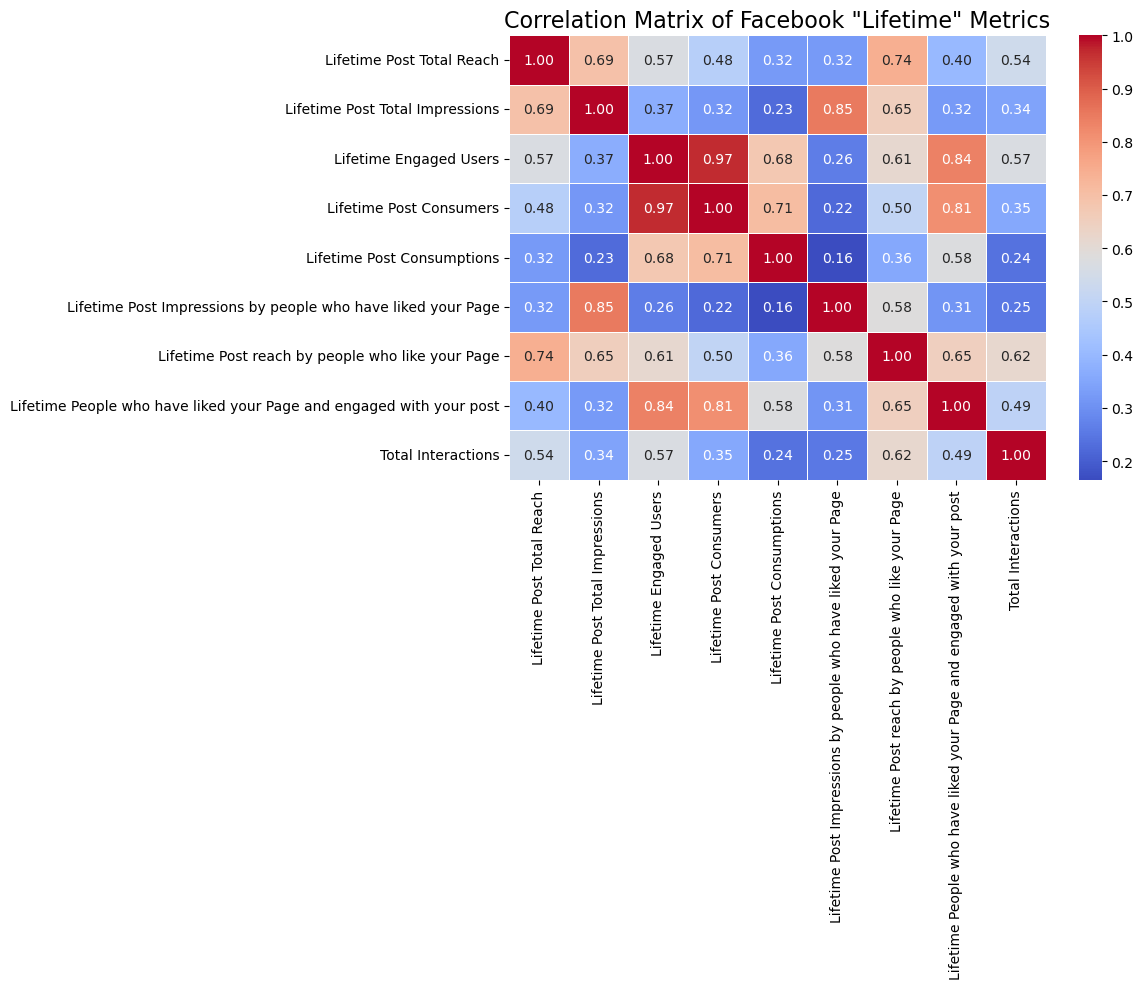

In [236]:
# we are interested in the multicollinearity between the detailed engagement and reach metrics.

lifetime_columns = [
    'Lifetime Post Total Reach',
    'Lifetime Post Total Impressions',
    'Lifetime Engaged Users',
    'Lifetime Post Consumers',
    'Lifetime Post Consumptions',
    'Lifetime Post Impressions by people who have liked your Page',
    'Lifetime Post reach by people who like your Page',
    'Lifetime People who have liked your Page and engaged with your post',
    'Total Interactions' # including the preliminary target variable for context
]

# create a new dataframe with only these columns and drop any rows with missing values
df_corr = df[lifetime_columns].dropna()

#  create matrix
correlation_matrix = df_corr.corr()

# generate heatmap and show
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

plt.title('Correlation Matrix of Facebook "Lifetime" Metrics', fontsize=16)
plt.tight_layout()

plt.show()

After assessing the possible central metrics that explain user engagement, 'Total Interactions' remains the best suited. The correlation matrix above shows that Lifetime Engaged Users (0.57) and Lifetime Post Total Reach (0.54) are the two metrics most strongly correlated with Total Interactions. This confirms that "Total Interactions" is a highly central metric for measuring the overall success of a post's engagement. 

### 1. What kinds of posts get the most engagement overall?

To find the answer for this goal, I am going to implement ANOVA to determine if there's statistically significant differences in the means for each post type's interaction metrics. ANOVA tests are fantastic ways to tell if variations between the means of two or more groups are due to random chance or reflect a geniune difference between them.

For a more robust analysis, I'll repeat the process for all different kinds of interactions (Comments, likes, shares) as well as Total Interactions. Ideally, this phase of the analysis will reveal if different post types lead to different interaction outcomes, and specifically which kinds of posts lead to different outcomes for each interaction type. 

ANOVA testing requires a few different assumptions to be met in order for it's results to be confidently interpreted. I'm planning on checking each of it's requisite assumptions, and if we find that our data doesn't hold up, we will pivot to a different kind of statistical testing to move forward with our analysis.

#### 1.1 Preliminary Visualizations

Boxplots will be our primary means of visualizing the data in this analysis. They provide compact and effective ways to compare the medians, spreads, and outliers across multiple groups.

Text(0.5, 1.0, 'Distribution of Total Interactions vs. Content Type')

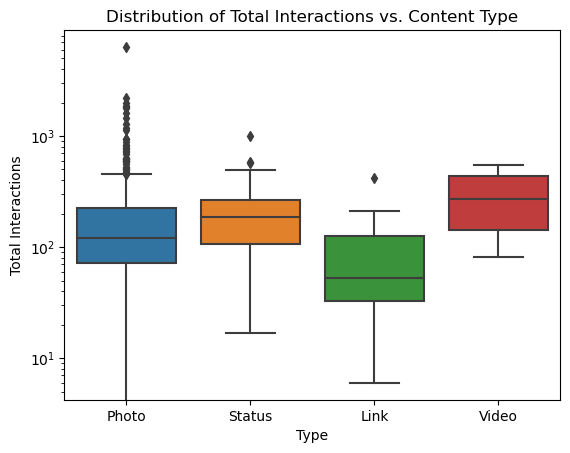

In [199]:
sns.boxplot(y=df['Total Interactions'],x=df['Type'])
plt.yscale('log') #  using a log scale for the y-axis helps visualize differences
plt.title("Distribution of Total Interactions vs. Content Type")

Text(0.5, 1.0, 'Distribution of Likes vs. Content Type')

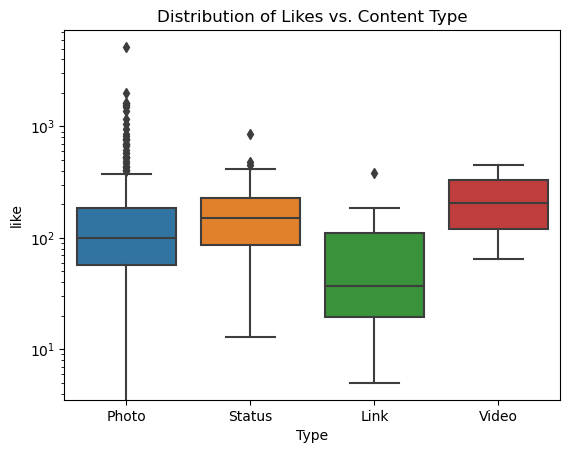

In [200]:
sns.boxplot(y=df['like'],x=df['Type'])
plt.yscale('log')
plt.title("Distribution of Likes vs. Content Type")

Text(0.5, 1.0, 'Distribution of Comments vs. Content Type')

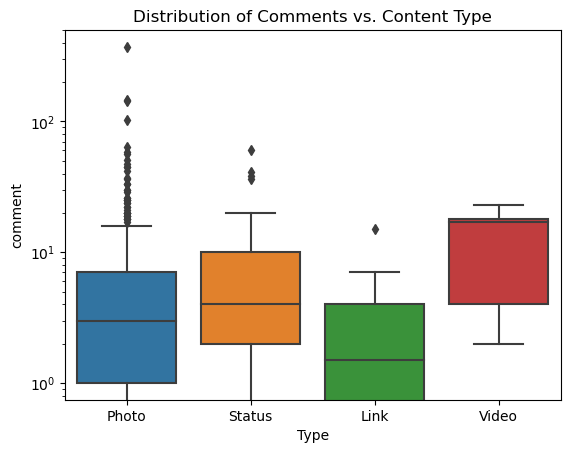

In [201]:
sns.boxplot(y=df['comment'],x=df['Type'])
plt.yscale('log')
plt.title("Distribution of Comments vs. Content Type")

Text(0.5, 1.0, 'Distribution of Shares vs. Content Type')

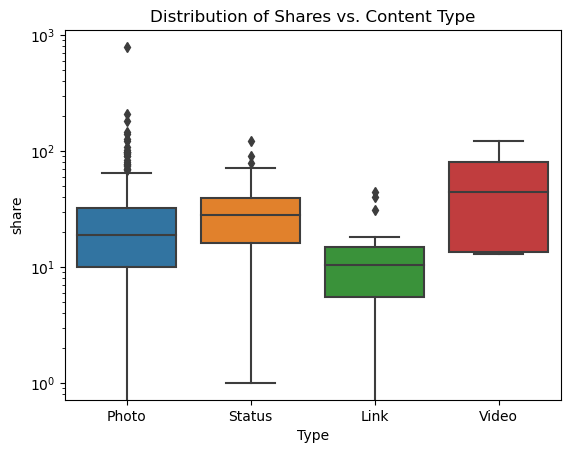

In [202]:
sns.boxplot(y=df['share'],x=df['Type'])
plt.yscale('log')
plt.title("Distribution of Shares vs. Content Type")

Based on these visualizations, we can see some rough trends in the data. Posts that are of the type Link appear broadly lower than Photo, Status, and Video types across different engagement metrics, and additionally has a much tighter spread in comparison to the different content types here. 

Posts of Photos have much more high outliers for every interaction type compared to other types of posts, which could indicate that posting photos can give pages more chances at virality. 

Important: The extremely high outlier for Photo, seen in the top-left of each of these box plots, will get left in the data, at least for now. This datapoint, while possibly interfering with the upcoming ANOVA analysis validity, might be representative of a post that truly went viral, something that a content strategist would be concerned with. We will move forward with this datapoint included in the data, and we will determine if it is negatively impacting the validity of our tests later.

Overall, from this early look at the data, we can tell that between photo, status, and video posts, there doesn't seem to be any clear indication of which one is "better" for generating engagement; their IQR boxes are all heavily overlapped, and none clearly stand out as superior. Still, we're going to move forward with ANOVA, in hopes that less obvious discrepancies within the data can be discovered.

#### 1.2 Preparing for ANOVA -- Assumption Checks

ANOVA is effective if the following assumptions are met about the data: 

1. The data within each group is normally distributed.
2. The variance of data within each group should be as close to equal as possible.

Implicitly, two other conditions for ANOVA testing have already been met: independent observations and random sampling. So, we only need to focus on determining if the data for each group is normal and equal in variance.

To start, we'll look at histograms for each post type to get a visual sense of their distribution. 

##### 1.2.1 Normality Checks on Untransformed data

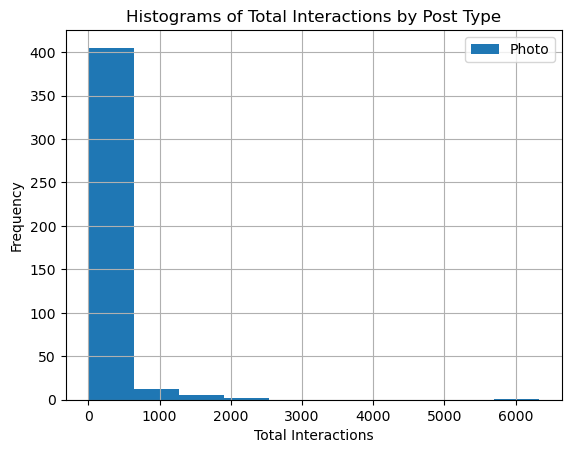

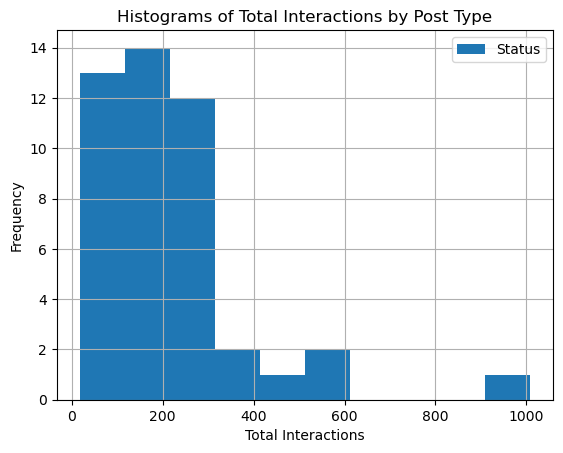

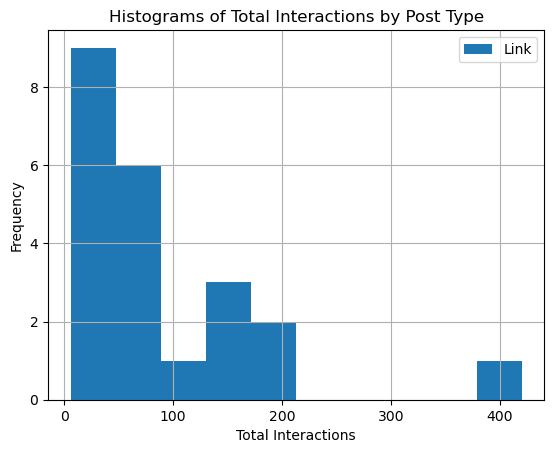

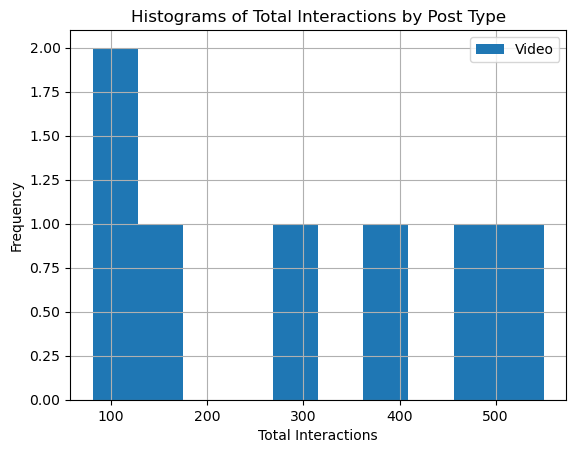

In [169]:
for post_type in df['Type'].unique(): #  using a for loop to create visualizations faster
    df[df['Type'] == post_type]['Total Interactions'].hist(label=post_type)
    plt.legend()
    plt.title('Histograms of Total Interactions by Post Type')
    plt.xlabel('Total Interactions')
    plt.ylabel('Frequency')
    plt.show()

##### 1.2.2 Normality Checks on Transformed Data

Majority of histograms for untransformed total interactions were right-skewed. Since ANOVA works best with normally distributed data, we will apply a log transformation to Total Interactions. Log transformations are highly useful for reducing the skewedness of the data, by enlarging smaller values and shrinking larger ones.

In [170]:
#  applying log transformation
df['Log_Total_Interactions'] = np.log(df['Total Interactions'] + 1)

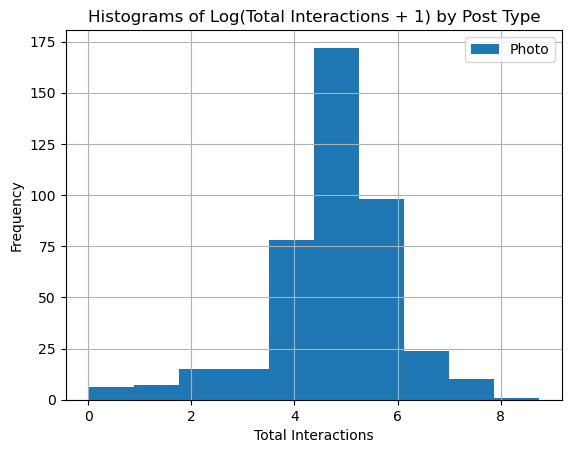

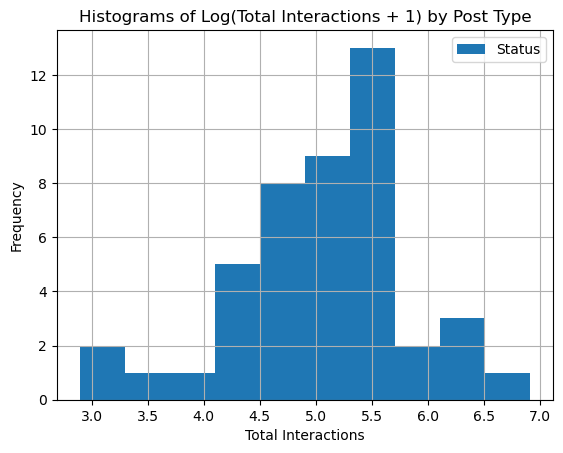

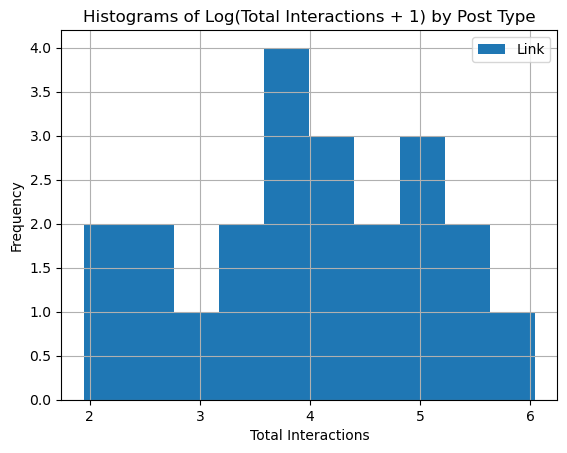

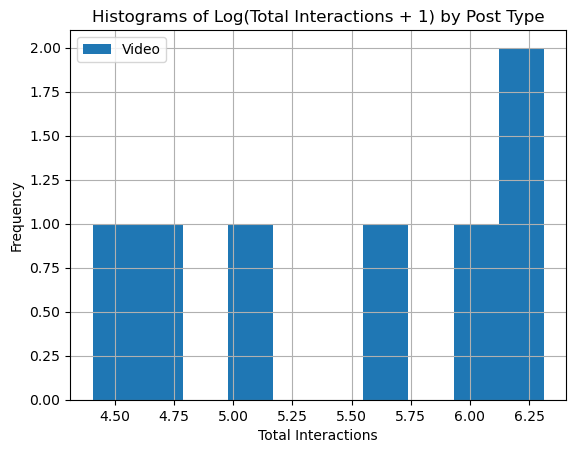

In [171]:
for post_type in df['Type'].unique():
    df[df['Type'] == post_type]['Log_Total_Interactions'].hist(label=post_type)
    plt.legend()
    plt.title('Histograms of Log(Total Interactions + 1) by Post Type')
    plt.xlabel('Total Interactions')
    plt.ylabel('Frequency')
    plt.show()

Visually, the histograms appear more normal with log transformation versus the untransformed data. But, visual confirmation isn't a dependable way to verify our normality assumption. For a more statistically robust check on the normality assumption, we will continue by using Shapiro-Wilkes testing with the log-transformed data.

In [172]:
for post_type in df['Type'].unique(): #  use a loop to repeat same test for different post types

    data_for_group = df[df['Type'] == post_type]['Log_Total_Interactions'].dropna() # drop missing values from group data

    shapiro_statistic, shapiro_p_value = stats.shapiro(data_for_group) 

#  printing relevant metrics
    print(f"Post Type: {post_type} (N = {len(data_for_group)})") #  prints post type and # of instances
    print(f"  W-statistic: {shapiro_statistic:.4f}")  #  as W-statistic approaches 1, the data is more normal
    print(f"  P-value: {shapiro_p_value:.4f}") 
 
#  interperet p value
    if shapiro_p_value > 0.05: 
        print("  Interpretation: Fail to reject H0. Data looks normally distributed.\n")
    else:
        print("  Interpretation: Reject H0. Data does NOT look normally distributed.\n")


Post Type: Photo (N = 426)
  W-statistic: 0.9206
  P-value: 0.0000
  Interpretation: Reject H0. Data does NOT look normally distributed.

Post Type: Status (N = 45)
  W-statistic: 0.9674
  P-value: 0.2323
  Interpretation: Fail to reject H0. Data looks normally distributed.

Post Type: Link (N = 22)
  W-statistic: 0.9767
  P-value: 0.8581
  Interpretation: Fail to reject H0. Data looks normally distributed.

Post Type: Video (N = 7)
  W-statistic: 0.9277
  P-value: 0.5313
  Interpretation: Fail to reject H0. Data looks normally distributed.



Remember, Video will not be included in the final analysis for this section. 

Photo did not past the Shaprio-Wilk normality test. This means that ANOVA results, which we were planning on initially, would become unreliable for interpretation. 

Because of this, we are going to pivot to a different kind of test to determine if there are statistically significant variations in distribution for total interactions across the different content types: the Kruskal-Wallis Test. This test doesn't assume normality like the ANOVA test, so it will be more suitable for our research objective given our data.


#### 1.3 Kruskal-Wallis Test

From our work in 1.2, we determined that the ANOVA test was NOT suitable for this research objective, since our data did not meet the normality assumption required, as evident from the results of our Shapiro-Wilk normality tests. Instead, we will use a Kruskal-Wallis test, since it does not require the data to be normally distributed. (Additionally, this sidesteps the issue of using discrete data with ANOVA -- the rank order style that Kruskal-Wallis is in essense discrete). 

In [270]:
engagement_metric_column = 'Total Interactions' 

# omit videos due to small sample size (n=7)
groups_to_compare = ['Photo', 'Status', 'Link']


df_filtered = df[df['Type'].isin(groups_to_compare)].copy()

group_data_list = []
for post_type in groups_to_compare:
    group_data = df_filtered[df_filtered['Type'] == post_type][engagement_metric_column].dropna()
    group_data_list.append(group_data)


h_statistic, p_value = kruskal(*group_data_list) 

print(f"Kruskal-Wallis Test Results")
print(f"    Dependent Variable: {engagement_metric_column}")
print(f"    Compared Groups: {groups_to_compare}")
print(f"    H-statistic: {h_statistic:.4f}")
print(f"    P-value: {p_value:.4f}\n")

    # interpretation
alpha = 0.05
if p_value < alpha:
    print(f"    Interpretation: Since the P-value ({p_value:.4f}) is less than alpha ({alpha}), we reject the null hypothesis.")
    print(f"    Conclusion: There is a statistically significant difference in the median {engagement_metric_column} among at least two of the post types ({', '.join(groups_to_compare)}).")
    
    # calculate Eta-squared
    n = sum(len(group) for group in group_data_list) # total number of observations
    k = len(group_data_list) # number of groups
    eta_squared = (h_statistic - k + 1) / (n - k)
    
    print(f"\nEffect Size")
    print(f"    Eta-squared: {eta_squared:.4f}")

    # interpret the effect size; using the norms for distinguishing effect strength 
    if eta_squared < 0.01:
        effect_size_interpretation = "Trivial effect"
    elif eta_squared < 0.06:
        effect_size_interpretation = "Small effect"
    elif eta_squared < 0.14:
        effect_size_interpretation = "Medium effect"
    else:
        effect_size_interpretation = "Large effect"
        
    print(f"    Interpretation: The effect size is considered to be a '{effect_size_interpretation}'. This means that approximately {eta_squared:.2%} of the variance in '{engagement_metric_column}' can be explained by the 'Type' of post.")

else:
    print(f"Interpretation: Since the P-value ({p_value:.4f}) is greater than or equal to alpha ({alpha}), we fail to reject the null hypothesis.")
    print(f"Conclusion: There is no statistically significant difference in the median {engagement_metric_column} among the post types ({', '.join(groups_to_compare)}).")

Kruskal-Wallis Test Results
    Dependent Variable: Total Interactions
    Compared Groups: ['Photo', 'Status', 'Link']
    H-statistic: 16.6760
    P-value: 0.0002

    Interpretation: Since the P-value (0.0002) is less than alpha (0.05), we reject the null hypothesis.
    Conclusion: There is a statistically significant difference in the median Total Interactions among at least two of the post types (Photo, Status, Link).

Effect Size
    Eta-squared: 0.0300
    Interpretation: The effect size is considered to be a 'Small effect'. This means that approximately 3.00% of the variance in 'Total Interactions' can be explained by the 'Type' of post.


From the Kruskal-Wallis test, we can be confident that there are statistically significant differences in median total interactions across the different kinds of content types included in the test (photo, link, or status). 

Next, we will use Dunn's test to identify which specific group pairs are different.

#### 1.4 Post-Hoc Testing: Dunn's Test

After determining that there exists statistically significant different median total interactions across different content types included in our Kruskal-Wallis tests, the next step is to perform post-hoc Dunn's tests in order to find the significant pair-wise differences across groups.

In [221]:
dunn_results = sp.posthoc_dunn(df_filtered,  # created in last cell
                                val_col=engagement_metric_column, #  setting Total Interactions as dependent variable
                                group_col='Type', #  setting independent variable
                                p_adjust='holm')  # using holm-bonferroni correction to better identify significant results and reduce false positives  

print(f"\nDunn's Post-Hoc Test Results")
print(f"Dependent Variable: {engagement_metric_column}")
print(dunn_results)


Dunn's Post-Hoc Test Results (p-values adjusted using Bonferroni)
Dependent Variable: Total Interactions
            Link     Photo    Status
Link    1.000000  0.002452  0.000133
Photo   0.002452  1.000000  0.023341
Status  0.000133  0.023341  1.000000


All pairwise relationships' P-values are lower than 0.05. This indicates that there are statistically significant differences in median Total Interactions between Link, Photo, and Status posts. 

In [222]:
#  print medians/iqr
median_engagement = df_filtered.groupby('Type')[engagement_metric_column].median() 
iqr_engagement = df_filtered.groupby('Type')[engagement_metric_column].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))

print("     Median Engagement")
print(median_engagement)
print("\n   IQR Engagement")
print(iqr_engagement)

     Median Engagement
Type
Link       52.5
Photo     122.0
Status    186.0
Name: Total Interactions, dtype: float64

       IQR Engagement
Type
Link       92.25
Photo     153.75
Status    159.00
Name: Total Interactions, dtype: float64


#### 1.5 Conclusions 

The Kruskal-Wallis test indicated a significant overall difference in 'Total Interactions' among the 'Link', 'Photo', and 'Status' post types (H = 16.6760, p = 0.0002). Subsequent post-hoc analysis using Dunn's test with Holm-Bonferroni p-value correction revealed significant pairwise discrepencies in median Total Interactions between all post types. 

Since each pairwise relationship showed significant differences (as shown in the output produced by first cell in 1.4), we can use the medians for each post type and rank them to determine which one produces, on average, the highest median Total Interactions as follows:

1. Status (186.0)
2. Photo (122.0)
3. Link (52.5)

This analysis reveals a clear performance hierarchy. On average, Status posts generate 52% more interactions than Photo posts and a remarkable 254% more interactions than Link posts. Furthermore, Photo posts outperform Link posts by 132%.

These findings strongly suggest that for maximizing organic engagement, the content strategy should prioritize 'Status' and 'Photo' updates. 'Link' posts, performing significantly worse than the other formats, should be used more sparingly or be prime candidates for paid promotion to boost their visibility. The 'Video' category was excluded from this statistical comparison due to its small sample size but was analyzed descriptively.



### 2. What is the best time to post to maximize engagement?

For consistency, lets move forward with our post scheduling analysis using a similar methodology: Kruskal-Wallis tests for post month, weekday, and hour. If we find that there exists significant differences within each level of each time frame, we will then use Dunn's test to find the specific pairwise relationships that differences occur.

#### 2.1 Month analysis

<Axes: xlabel='Post Month', ylabel='Total Interactions'>

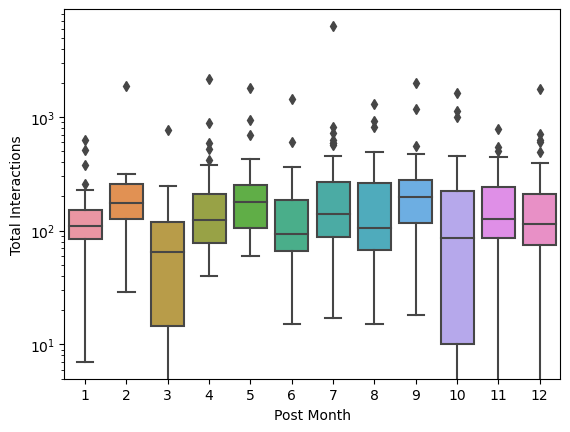

In [203]:
#  1 -> January, 2 -> February ... 12 -> December
df['Post Month'] = df['Post Month'].astype('category') #  ensure month is treated as a categorical variable, not integer
plt.yscale('log')
sns.boxplot(y=df['Total Interactions'],x=df['Post Month'])



In [178]:
median_engagement_month = df.groupby('Post Month')['Total Interactions'].median().reset_index()
print("\nMedian Engagement by Month:")
#print(median_engagement_month)
median_engagement_month


Median Engagement by Month:


,Post Month,Total Interactions
0,1,110.0
1,2,174.0
2,3,65.0
3,4,123.0
4,5,179.0
5,6,94.0
6,7,141.0
7,8,105.0
8,9,196.5
9,10,86.5


In [268]:
#  kruskal wallis for month

engagement_metric_column = 'Total Interactions' #  using the transformed data isn't necessary here. using the original scale may improve interprebility

groups_to_compare = [1,2,3,4,5,6,7,8,9,10,11,12]

df_filtered = df[df['Post Month'].isin(groups_to_compare)].copy()

group_data_list = []
for post_month in groups_to_compare:
    group_data = df_filtered[df_filtered['Post Month'] == post_month][engagement_metric_column].dropna()
    group_data_list.append(group_data)


h_statistic, p_value = kruskal(*group_data_list)

print(f"Kruskal-Wallis Test Results:")
print(f"    Dependent Variable: {engagement_metric_column}")
print(f"    Compared Groups: {groups_to_compare}")
print(f"    H-statistic: {h_statistic:.4f}")
print(f"    P-value: {p_value:.4f}")

#  calculate eta squared
n = sum(len(group) for group in group_data_list) # total number of observations
k = len(group_data_list) # number of groups
eta_squared = (h_statistic - k + 1) / (n - k)
    
print(f"\nEffect Size:")
print(f"    Eta-squared: {eta_squared:.4f}")

# interpreting the effect size
if eta_squared < 0.01:
    effect_size_interpretation = "Trivial effect"
elif eta_squared < 0.06:
    effect_size_interpretation = "Small effect"
elif eta_squared < 0.14:
    effect_size_interpretation = "Medium effect"
else:
    effect_size_interpretation = "Large effect"
        
print(f"    Interpretation: The effect size is considered to be a '{effect_size_interpretation}'. This means that approximately {eta_squared:.2%} of the variance in '{engagement_metric_column}' can be explained by the month of post.")
    

# interpretation
alpha = 0.05
if p_value < alpha:
    print(f"\nInterpretation: Since the P-value ({p_value:.4f}) is less than alpha ({alpha}), we reject the null hypothesis.")
    print("Conclusion: There is a statistically significant difference in the median {engagement_metric_column} among at least two of the post types ({', '.join(groups_to_compare)}).")
else:
    print(f"\nInterpretation: Since the P-value ({p_value:.4f}) is greater than or equal to alpha ({alpha}), we fail to reject the null hypothesis.")
    print(f"Conclusion: There is no statistically significant difference in the median {engagement_metric_column} among the post types ({', '.join(groups_to_compare)}).")

Kruskal-Wallis Test Results:
    Dependent Variable: Total Interactions
    Compared Groups: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    H-statistic: 46.3195
    P-value: 0.0000

Effect Size:
    Eta-squared: 0.0724
    Interpretation: The effect size is considered to be a 'Medium effect'. This means that approximately 7.24% of the variance in 'Total Interactions' can be explained by the month of post.

Interpretation: Since the P-value (0.0000) is less than alpha (0.05), we reject the null hypothesis.
Conclusion: There is a statistically significant difference in the median {engagement_metric_column} among at least two of the post types ({', '.join(groups_to_compare)}).


In [224]:
dunn_results = sp.posthoc_dunn(df_filtered, 
                                val_col=engagement_metric_column, 
                                group_col='Post Month', 
                                p_adjust='holm')

print(f"\n  Dunn's Post-Hoc Test Results (p-values adjusted using Bonferroni)")
print(f"Dependent Variable: {engagement_metric_column}")
print(dunn_results)


  Dunn's Post-Hoc Test Results (p-values adjusted using Bonferroni)
Dependent Variable: Total Interactions
           1         2         3         4         5         6         7  \
1   1.000000  1.000000  0.573416  1.000000  1.000000  1.000000  1.000000   
2   1.000000  1.000000  0.001735  1.000000  1.000000  0.709068  1.000000   
3   0.573416  0.001735  1.000000  0.018155  0.000173  1.000000  0.001297   
4   1.000000  1.000000  0.018155  1.000000  1.000000  1.000000  1.000000   
5   1.000000  1.000000  0.000173  1.000000  1.000000  0.251434  1.000000   
6   1.000000  0.709068  1.000000  1.000000  0.251434  1.000000  1.000000   
7   1.000000  1.000000  0.001297  1.000000  1.000000  1.000000  1.000000   
8   1.000000  1.000000  0.187360  1.000000  1.000000  1.000000  1.000000   
9   1.000000  1.000000  0.000128  1.000000  1.000000  0.191204  1.000000   
10  1.000000  0.189580  1.000000  1.000000  0.041554  1.000000  0.256471   
11  1.000000  1.000000  0.018155  1.000000  1.000000  1.

significant pairwise relationships found between:
- March (65.0), February (174.0)
- April (123.0), March (65.0)
- July (141.0),March (65.0)
- March (65.0),May (179.0)
- March (65.0), September (196.5)
- May (179.0), October (86.5)
- March (65.0), November (126.0)
- September (196.5), October (86.5)



The Kruskal-Wallis H test revealed a statistically significant difference in median 'Total Engagement' across the 12 months of the year (H = 46.3195, p = 0.0000). Dunn's post-hoc tests with Holm-Bonferroni correction were conducted to identify specific monthly differences:

- A key finding was the performance of March (Median = 65.0), which exhibited significantly lower median 'Total Engagement' compared to February (Median = 174.0, adj. p = 0.001971), April (Median = 123.0, adj. p = 0.020370), May (Median = 179.0, adj. p = 0.000189), July (Median = 141.0, adj. p = 0.000802), September (Median = 196.5, adj. p = 0.000062), and November (Median = 126.0, adj. p = 0.014692).

- Conversely, September (Median = 196.5) and May (Median = 179.0) were identified as months with particularly high engagement, with both significantly outperforming October (Median = 86.5, adj. p-values = 0.018877 and 0.049376 respectively). February (Median = 174.0) also demonstrated strong performance, significantly exceeding March's engagement levels.

These differences reveals the strategic importance of timing. For instance, the top-performing month, September, generated 127% more median interactions than October. Similarly, February and May saw 168% and 175% more median interactions than March, respectively.

These patterns suggest that for this Facebook page, late winter/spring (February, May) and early autumn (September) represent periods of heightened user engagement. Scheduling strategies could leverage these insights by aligning key content releases with these higher-performing months.

Actionable steps:
- February, May, and September could be particularly strong months for content engagement. These might be ideal times for launching important campaigns or content where high organic interaction is the goal.
- April, July, and November, while not reaching the peaks of Feb/May/Sep in the dataset, still performed significantly better than March and could be considered generally strong times to schedule content.
- March consistently showed the lowest engagement relative to many other months. During March, it might be necessary to adjust expectations for engagement, potentially increase posting frequency, use different content strategies, or allocating more resources towards paid promotions.

It is important to consider that this analysis is based on data from a single year period. While these monthly patterns are statistically significant within this dataset, confirming true recurring seasonality would ideally involve analyzing data across multiple years to account for year-specific anomalies or evolving audience behavior.

#### 2.2 Weekday analysis 

<Axes: xlabel='Post Weekday', ylabel='Total Interactions'>

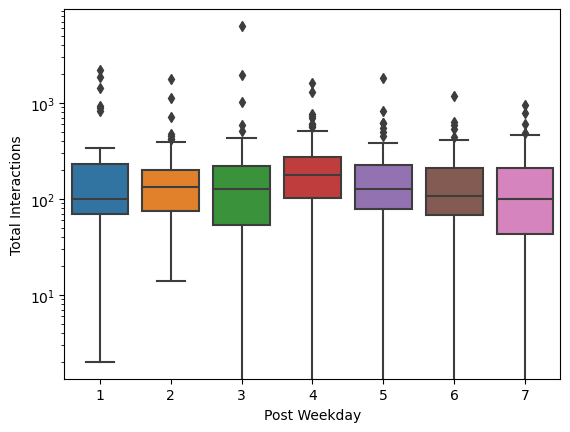

In [204]:
#  1 -> Sunday, 2 -> Monday ... 7 -> Saturday
df['Post Weekday'] = df['Post Weekday'].astype('category') #  ensure month is treated as a categorical variable, not integer
plt.yscale('log')
sns.boxplot(y=df['Total Interactions'],x=df['Post Weekday'])


In [182]:
median_engagement_weekday = df.groupby('Post Weekday')['Total Interactions'].median().reset_index()
print("\nMedian Engagement by Weekday:")
median_engagement_weekday


Median Engagement by Weekday:


,Post Weekday,Total Interactions
0,1,98.5
1,2,133.5
2,3,126.0
3,4,177.0
4,5,127.0
5,6,107.0
6,7,100.5


In [269]:
#  kruskal wallis for weekday

engagement_metric_column = 'Total Interactions' #  using the transformed data isn't necessary here. using the original scale may improve interprebility


# omit videos due to small sample size (n=7)
groups_to_compare = [1,2,3,4,5,6,7]


df_filtered = df[df['Post Weekday'].isin(groups_to_compare)].copy() #  filter df for weekday

group_data_list = []
for post_weekday in groups_to_compare:
    group_data = df_filtered[df_filtered['Post Weekday'] == post_weekday][engagement_metric_column].dropna()
    group_data_list.append(group_data)



h_statistic, p_value = kruskal(*group_data_list)

print(f"Kruskal-Wallis Test Results:")
print(f"    Dependent Variable: {engagement_metric_column}")
print(f"    Compared Groups: {groups_to_compare}")
print(f"    H-statistic: {h_statistic:.4f}")
print(f"    P-value: {p_value:.4f}")

#  calculate eta squared
n = sum(len(group) for group in group_data_list) # total number of observations
k = len(group_data_list) # number of groups
eta_squared = (h_statistic - k + 1) / (n - k)

print(f"\nEffect Size:")
print(f"    Eta-squared: {eta_squared:.4f}")

# interpreting the effect size
if eta_squared < 0.01:
    effect_size_interpretation = "Trivial effect"
elif eta_squared < 0.06:
    effect_size_interpretation = "Small effect"
elif eta_squared < 0.14:
    effect_size_interpretation = "Medium effect"
else:
    effect_size_interpretation = "Large effect"
    
print(f"    Interpretation: The effect size is considered to be a '{effect_size_interpretation}'. This means that approximately {eta_squared:.2%} of the variance in '{engagement_metric_column}' can be explained by the weekday of post.")


# Interpretation
alpha = 0.05
if p_value < alpha:
    print(f"\nInterpretation: Since the P-value ({p_value:.4f}) is less than alpha ({alpha}), we reject the null hypothesis.")
    # Convert integers to strings for joining
    print(f"Conclusion: There is a statistically significant difference in the median {engagement_metric_column} among at least two of the post types ({', '.join(map(str, groups_to_compare))}).")
else:
    print(f"Interpretation: Since the P-value ({p_value:.4f}) is greater than or equal to alpha ({alpha}), we fail to reject the null hypothesis.")
    # Convert integers to strings for joining
    print(f"Conclusion: There is no statistically significant difference in the median {engagement_metric_column} among the post types ({', '.join(map(str, groups_to_compare))}).")

Kruskal-Wallis Test Results:
    Dependent Variable: Total Interactions
    Compared Groups: [1, 2, 3, 4, 5, 6, 7]
    H-statistic: 16.7948
    P-value: 0.0101

Effect Size:
    Eta-squared: 0.0219
    Interpretation: The effect size is considered to be a 'Small effect'. This means that approximately 2.19% of the variance in 'Total Interactions' can be explained by the weekday of post.

Interpretation: Since the P-value (0.0101) is less than alpha (0.05), we reject the null hypothesis.
Conclusion: There is a statistically significant difference in the median Total Interactions among at least two of the post types (1, 2, 3, 4, 5, 6, 7).


In [229]:
#  1 -> Sunday, 2 -> Monday ... 7 -> Saturday

dunn_results = sp.posthoc_dunn(df_filtered, 
                                val_col=engagement_metric_column, 
                                group_col='Post Weekday', 
                                p_adjust='holm')

print(f"\n    Dunn's Post-Hoc Test Results (p-values adjusted using Holm-Bonferroni)")
print(f"Dependent Variable: {engagement_metric_column}")
print(dunn_results)


    Dunn's Post-Hoc Test Results (p-values adjusted using Holm-Bonferroni)
Dependent Variable: Total Interactions
          1         2        3         4    5        6         7
1  1.000000  1.000000  1.00000  0.153907  1.0  1.00000  1.000000
2  1.000000  1.000000  1.00000  0.669519  1.0  1.00000  1.000000
3  1.000000  1.000000  1.00000  0.255770  1.0  1.00000  1.000000
4  0.153907  0.669519  0.25577  1.000000  1.0  0.03124  0.003953
5  1.000000  1.000000  1.00000  1.000000  1.0  1.00000  1.000000
6  1.000000  1.000000  1.00000  0.031240  1.0  1.00000  1.000000
7  1.000000  1.000000  1.00000  0.003953  1.0  1.00000  1.000000


significant pairwise relationships found between:
- Wednesday (177.0),Friday (107.0)
- Wednesday (177.0), Saturday (100.5)




The Kruskal-Wallis test revealed an overall statistically significant difference in median total engagement across the weekdays (H = 16.7948, p = 0.0101). Dunn's post-hoc tests identified that Wednesday stands out as the day with the highest median total engagement.

The median interactions for the key days are:

- Wednesday: 177.0

- Friday: 107.0

- Saturday: 100.5

These significant differences shows the potential impact of a mid-week posting strategy. Posts made on Wednesday generated 65% more median interactions than posts on Friday and 76% more than posts on Saturday on average.

These findings indicate that Wednesday is the most effective day for maximizing 'Total Interactions' when compared to the weekend. While engagement levels on Wednesday were not statistically different from other weekdays, its significant outperformance of Friday and Saturday makes it a strategically important day for scheduling key content.

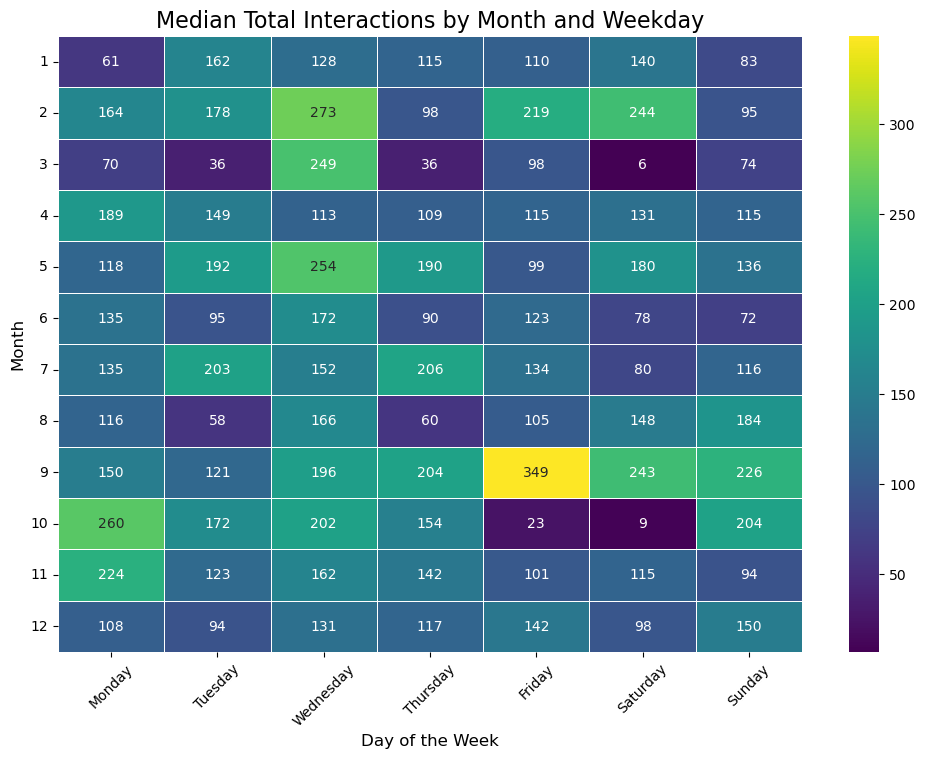

In [208]:


# making heatmap
pivot_table = df.pivot_table(values='Total Interactions',
                             index='Post Month',
                             columns='Post Weekday',
                             aggfunc='median')

# put weekdays in order
weekday_map = {
    1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday',
    5: 'Thursday', 6: 'Friday', 7: 'Saturday'
}
pivot_table.columns = [weekday_map[col] for col in pivot_table.columns]

# reorder columns to be in correct order (monday to sunday)
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table[ordered_days]


plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="viridis", linewidths=.5)

# adding titles
plt.title('Median Total Interactions by Month and Weekday', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


#### 2.3 Hour Analysis

<Axes: xlabel='Post Hour', ylabel='Total Interactions'>

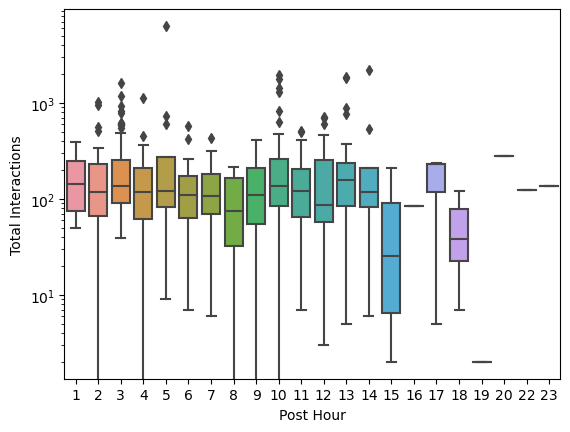

In [205]:
df['Post Hour'] = df['Post Hour'].astype('category') #  ensure hour is treated as a categorical variable, not integer
plt.yscale('log')
sns.boxplot(y=df['Total Interactions'],x=df['Post Hour'])

In [186]:
median_engagement_hour = df.groupby('Post Hour')['Total Interactions'].median().reset_index()
print("\nMedian Engagement by Hour:")
#print(median_engagement_month)
median_engagement_hour


Median Engagement by Hour:


,Post Hour,Total Interactions
0,1,143.5
1,2,117.0
2,3,135.0
3,4,119.0
4,5,122.0
5,6,110.5
6,7,108.0
7,8,74.0
8,9,110.5
9,10,136.0


hour 21 is missing

In [266]:
#  kruskal wallis for hour

engagement_metric_column = 'Total Interactions' #  using the transformed data isn't necessary here. using the original scale may improve interprebility


# omit videos due to small sample size (n=7)
groups_to_compare = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23]


df_filtered = df[df['Post Hour'].isin(groups_to_compare)].copy()

group_data_list = []
for post_hour in groups_to_compare:
    group_data = df_filtered[df_filtered['Post Hour'] == post_hour][engagement_metric_column].dropna()
    if len(group_data) >= 1: # Kruskal-Wallis needs at least one observation per group ideally more
        group_data_list.append(group_data)
    else:
        print(f"Warning: Group '{post_type}' has no data after filtering and dropna.")

# Check if you have at least two groups with data to compare
if len(group_data_list) < 2:
    print("Kruskal-Wallis test requires at least two groups with data to compare.")
else:
    # Perform the Kruskal-Wallis test
    h_statistic, p_value = kruskal(*group_data_list) # The * unpacks the list of arrays

    print(f"Kruskal-Wallis Test Results:")
    print(f"    Dependent Variable: {engagement_metric_column}")
    print(f"    Compared Groups: {groups_to_compare}")
    print(f"    H-statistic: {h_statistic:.4f}")
    print(f"    P-value: {p_value:.4f}")

    # Interpretation
    n = sum(len(group) for group in group_data_list) # Total number of observations
    k = len(group_data_list) # Number of groups
    eta_squared = (h_statistic - k + 1) / (n - k)
    
    print(f"\nEffect Size:")
    print(f"    Eta-squared: {eta_squared:.4f}")

    # Interpret the effect size
    if eta_squared < 0.01:
        effect_size_interpretation = "Trivial effect"
    elif eta_squared < 0.06:
        effect_size_interpretation = "Small effect"
    elif eta_squared < 0.14:
        effect_size_interpretation = "Medium effect"
    else:
        effect_size_interpretation = "Large effect"
        
    print(f"    Interpretation: The effect size is considered to be a '{effect_size_interpretation}'. This means that approximately {eta_squared:.2%} of the variance in '{engagement_metric_column}' can be explained by the hour of post.")
    
alpha = 0.05
if p_value < alpha:
    print(f"\nInterpretation: Since the P-value ({p_value:.4f}) is less than alpha ({alpha}), we reject the null hypothesis.")
    # Convert integers to strings for joining
    print(f"Conclusion: There is a statistically significant difference in the median {engagement_metric_column} among at least two of the post types ({', '.join(map(str, groups_to_compare))}).")
else:
    print(f"\nInterpretation: Since the P-value ({p_value:.4f}) is greater than or equal to alpha ({alpha}), we fail to reject the null hypothesis.")
    # Convert integers to strings for joining
    print(f"Conclusion: There is no statistically significant difference in the median {engagement_metric_column} among the post hours ({', '.join(map(str, groups_to_compare))}).")

Kruskal-Wallis Test Results:
    Dependent Variable: Total Interactions
    Compared Groups: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23]
    H-statistic: 29.4067
    P-value: 0.1046

Effect Size:
    Eta-squared: 0.0176
    Interpretation: The effect size is considered to be a 'Small effect'. This means that approximately 1.76% of the variance in 'Total Interactions' can be explained by the hour of post.

Interpretation: Since the P-value (0.1046) is greater than or equal to alpha (0.05), we fail to reject the null hypothesis.
Conclusion: There is no statistically significant difference in the median Total Interactions among the post hours (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23).


Since there isn't a statistically significant different in median total interactions across each post hour, we can reasonably conclude that strategizing content posts across different times of day is unlikely to create substantial differences in resulting post interactions. 

However, this conclusion can be challenged in that post hour 21 is not included in the dataset. 

#### 2.4 Overall Conclusions From Post Scheduling Analysis

<p> Our analysis across post Month, Weekday, and Hour and their relation to median Total Engagement showed statistically significant variations in month and weekday, but not hour. 

We determined that the peak months for generating engagement were September, May, and January, with the comparitively lowest engagment being seen in the month of March. This finding might indicate that, for this particular account, key content and campaigns should be scheduled during peak months (February, May, September) to maximize organic interaction. During low-engagement months like March, it may be beneficial to adjust content strategies or increase promotional spending. 

As for weekly engagement trends, we also identified significant differences in median post interaction, where Wednesday is the peak day of the week for maximizing engagement. Friday and Saturday, conversely, exhibited the least amount of post interaction. Therefore, on a weekly basis, important content might be best suited for posting on Wednesdays and avoided on Fridays and Saturdays.

Lastly, the analysis found no statistically significant difference in engagement based on the hour a post was made. This suggests that the specific time of day is less critical for engagement strategy. However, this conclusion is limited as data for the 9 PM (21:00) hour was not included in the dataset (which could be attributed to either no posts being made during that time in the dataset, or simply the limitations of the dataset itself). 

Importantly, taking actions based on these conclusions should be made with the understanding that the data used in this analysis is limited to just one year. This means that, for our month analysis, it can't be known if our findings are representative of a true seasonal pattern in post interactions or not. 

Next, we will determine the impact of paid promotions on total interaction.

### 3. How big of a role does paying for posts have? On what kinds of posts is paying most effective?

This research goal, at its simplest level, is about finding if there's a significant advantage that can be gained in terms of Total Interactions depending on if the page pays for promotion on a post or not. It will also be interesting to see if the efficacy of paid promotion varys depending on post type (Photo, status, or links). Doing both of these steps can provide insight on if paying for posts, in general, is beneficial for driving engagement, and further, if it's necessary to prioritize paid promotions on certain kinds of posts that may be more impacted by it. Finding out these research goals can allow a social media team to more effectively allocate promotional budgets towards content that will be most positively impacted by it, possibly reducing wasted money and improving interactions in a targeted way.

#### 3.1 Exploratory Analysis And Visualizations

To start, we'll check the values in the Paid column for missing data. Missing values will be dropped from the dataset.

In [261]:
# Check the current state of the 'Paid' column, including NaNs
print("Value counts for 'Paid' before cleaning:")
print(df['Paid'].value_counts(dropna=False))

# drop the single row where 'Paid' is NaN
# also drop the few rows where 'like' or 'share' are NaN to have a clean dataset for this section
df_paid_analysis = df.dropna(subset=['Paid', 'like', 'share']).copy()

# convert the 'Paid' column to integer first
df_paid_analysis['Paid'] = df_paid_analysis['Paid'].astype(int)

# map 0 to Unpaid and 1 to Paid for easier readability
df_paid_analysis['Paid_Status'] = df_paid_analysis['Paid'].map({0: 'Unpaid', 1: 'Paid'})

print("\nValue counts for 'Paid_Status' after cleaning:")
print(df_paid_analysis['Paid_Status'].value_counts())

Value counts for 'Paid' column before cleaning:
Paid
0.0    360
1.0    139
NaN      1
Name: count, dtype: int64

Value counts for 'Paid_Status' column after cleaning:
Paid_Status
Unpaid    356
Paid      139
Name: count, dtype: int64


5 total observations dropped, leaving us plenty of room to continue the analysis.

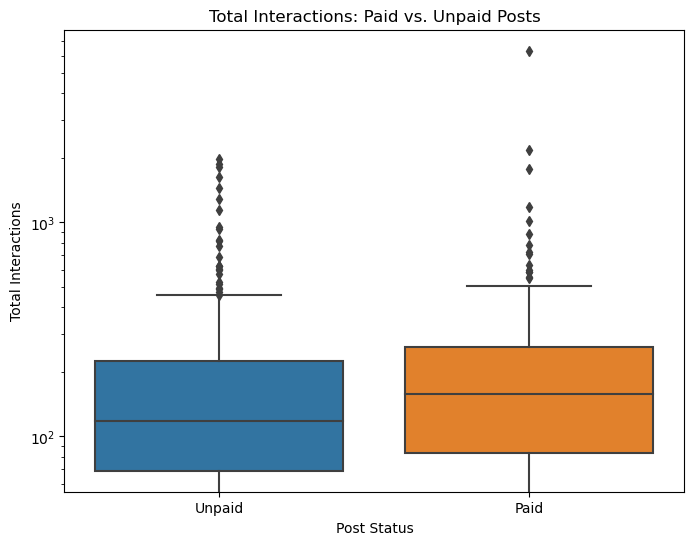

In [206]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Paid_Status', y='Total Interactions', data=df_paid_analysis)
plt.title('Total Interactions: Paid vs. Unpaid Posts')
plt.ylabel('Total Interactions')
plt.yscale('log')
plt.xlabel('Post Status')
plt.show()

Here, we can see that paid posts seem to have a slight advantage in median Total interactions. However, each show highly similar IQR boxes and ranges. This indicates that across all post types, we can expect a similar distribution of Total Interactions. It will be interesting to see if this relationship is reflected in each post type, or if this is a consistent theme across each.

In [262]:


#  mann-whitney u test
unpaid_interactions = df_paid_analysis[df_paid_analysis['Paid_Status'] == 'Unpaid']['Total Interactions']
paid_interactions = df_paid_analysis[df_paid_analysis['Paid_Status'] == 'Paid']['Total Interactions']

u_statistic, p_value = mannwhitneyu(paid_interactions, unpaid_interactions, alternative='two-sided')

print("\nMann-Whitney U Test Results, comparing Paid vs. Unpaid")
print(f"U-statistic: {u_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# interpretation
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: There is a statistically significant difference in median 'Total Interactions' between Paid and Unpaid posts.")
else:
    print("\nConclusion: There is no statistically significant difference in median 'Total Interactions' between Paid and Unpaid posts.")

# include medians for additional context
print(f"Median for Unpaid posts: {unpaid_interactions.median()}")
print(f"Median for Paid posts: {paid_interactions.median()}")


Mann-Whitney U Test Results, comparing Paid vs. Unpaid
U-statistic: 28215.5000
P-value: 0.0152

Conclusion: There is a statistically significant difference in median 'Total Interactions' between Paid and Unpaid posts.
Median for Unpaid posts: 118.0
Median for Paid posts: 158.0


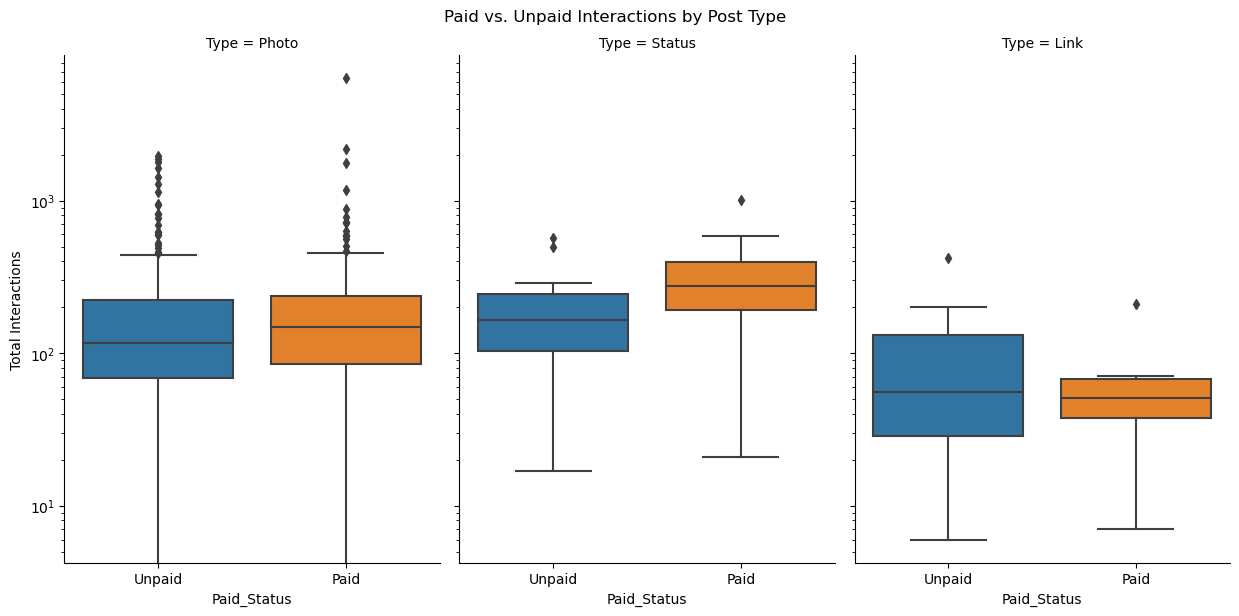


Mann-Whitney U Tests by Post Type:

Analysis for 'Photo' posts:
Median (Unpaid): 117.00 (n=302)
Median (Paid): 149.00 (n=119)
P-value: 0.0203
Conclusion: Significant difference found.

Analysis for 'Status' posts:
Median (Unpaid): 164.00 (n=35)
Median (Paid): 277.50 (n=10)
P-value: 0.0615
Conclusion: No significant difference found.

Analysis for 'Link' posts:
Median (Unpaid): 56.00 (n=16)
Median (Paid): 51.00 (n=6)
P-value: 0.7963
Conclusion: No significant difference found.


In [258]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

df_filtered_types = df_paid_analysis[df_paid_analysis['Type'].isin(['Photo', 'Status', 'Link'])] #  filter out videos due to sample size

sns.catplot(x='Paid_Status', y='Total Interactions', col='Type', 
            data=df_filtered_types, kind='box', height=6, aspect=.7)
plt.suptitle('Paid vs. Unpaid Interactions by Post Type', y=1.02)
plt.yscale('log')
plt.show()


post_types_to_test = ['Photo', 'Status', 'Link']
alpha = 0.05

print("\nMann-Whitney U Tests by Post Type:")

for p_type in post_types_to_test:
    print(f"\nAnalysis for '{p_type}' posts:")
    
    subset = df_filtered_types[df_filtered_types['Type'] == p_type]
    
    unpaid = subset[subset['Paid_Status'] == 'Unpaid']['Total Interactions']
    paid = subset[subset['Paid_Status'] == 'Paid']['Total Interactions']
    
    if len(unpaid) > 1 and len(paid) > 1:
        u_stat, p_val = mannwhitneyu(paid, unpaid, alternative='two-sided')
        
        print(f"Median (Unpaid): {unpaid.median():.2f} (n={len(unpaid)})")
        print(f"Median (Paid): {paid.median():.2f} (n={len(paid)})")
        print(f"P-value: {p_val:.4f}")
        
        if p_val < alpha:
            print("Conclusion: Significant difference found.")
        else:
            print("Conclusion: No significant difference found.")
    else:
        print("Not enough data in both Paid and Unpaid groups to perform the test.")

The results from this analysis reveals a compelling and actionable insight into the page's paid promotion strategy. While an initial test confirmed that paid posts, as a whole, perform significantly better than unpaid posts (p=0.0152), a more granular analysis shows this effect is driven almost entirely by Photo posts.

The analysis between paid and unpaid Photo posts found significant differences in median Total Interaction. Paid photo posts (median 149) significantly outperform unpaid photo posts (median 117), reflecting, on average, a 27% increase in Total Interactions.

Status Posts: There is no statistically significant difference between paid and unpaid Status posts (p = 0.0615).

Link Posts: Similarly, there is no statistically significant difference for Link posts (p = 0.7963).

Recommendation: The data strongly suggests that the promotional budget should be strategically focused on amplifying Photo posts. This is where the investment yields a significant and measurable lift in user interactions. Conversely, spending to promote 'Status' and 'Link' posts does not appear to provide a significant return and this portion of the budget could be reallocated to promoting more photos. It should be noted, additionally, that there is a substantially smaller sample size of status (n = 45) and link (n = 21) posts compared to photo posts (n = 421), and that the conclusions of this section may be contradicted with larger sample sizes. 

### 4. Using all available features, what are the most important variables for predicting total post engagement?

I am going to use a simple linear regression model first as a baseline. This will give us a good picture of whether a more complex model is justified.

Included in the dataset are variables for likes, comments, and shares (the sum of all 3 = Total Interactions); to avoid multicollinearity, we are going to preliminarily remove those features. 

Target variable: Total Post Interactions
Explanatory Vars: Type, Category, Post Month, Post Weekday, Post Hour, Paid

For evaluating the efficacy of a given model, I am going to use 5-fold cross validation. This allows us to evaluate models based on average metrics, helping to avoid some variance in scores that can arise out of random chance.


#### 4.1 Baseline Model: Simple Linear Regression

In [257]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

features = ['Type', 'Category', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid'] # features
target = 'Total Interactions' # target

# make a new dataframe for model and drop rows with missing values 
df_model = df[features + [target]].dropna().copy()

# Log-transform Total Interactions to fix skew, adding 1 to avoid log(0)
df_model['Log_Total_Interactions'] = np.log(df_model['Total Interactions'] + 1)
log_target = 'Log_Total_Interactions'

# Separate features and target variable
X = df_model[features]
y = df_model[log_target]

categorical_features = ['Type', 'Category', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid'] #  features for one-hot encoding

# creating a pipeline will streamline the process and ensure no data leaks

#  preprocessor should encode the categorical features to enable LR
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough' # in case we add numerical features later
)

# create the full pipeline including preprocessing and the linear regression model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler(with_mean=False)), # Use with_mean=False for sparse data from OneHotEncoder
    ('regressor', LinearRegression())
])

#  set up cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=2025)

r2_scores = []
rmse_scores = []

#  run cross validation
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    # splits data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fitting the pipeline on the training data
    model_pipeline.fit(X_train, y_train)
    
    # predict on the test data
    y_pred = model_pipeline.predict(X_test)
    
    # calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Fold {fold+1}/{n_folds}:") 
    print(f"    R-squared: {r2:.4f}, RMSE: {rmse:.4f}")


#  print results
print("\nBaseline Model Cross-Validation Summary:")
print(f"Average R-squared: {np.mean(r2_scores):.4f} (Std: {np.std(r2_scores):.4f})")
print(f"Average RMSE:      {np.mean(rmse_scores):.4f} (Std: {np.std(rmse_scores):.4f})")



Fold 1/5:
    R-squared: 0.2196, RMSE: 1.0297
Fold 2/5:
    R-squared: -0.0130, RMSE: 1.1924
Fold 3/5:
    R-squared: 0.2302, RMSE: 0.9941
Fold 4/5:
    R-squared: 0.1759, RMSE: 1.1652
Fold 5/5:
    R-squared: 0.1619, RMSE: 1.1337

Baseline Model Cross-Validation Summary:
Average R-squared: 0.1549 (Std: 0.0878)
Average RMSE:      1.1030 (Std: 0.0775)


Overall, the 5-fold simple linear regression model performed poorly, with an average R^2 of 0.16. This result indicates that a small amount of the complexity of the data can be captured with a simple model, I think that we can do better with a more sophisticated model. 

In this case, I think that a Random Forest model will perform strongly. This is because, unlike linear regression models, Random Forest has a distinct advantage when it comes to identifying complex, non-linear patterns in the data, which can be especially useful in analyzing the non-linearity of social media metrics. Multiple linear regression is additionally held back in this case since it assigns impact independently to features, rather than being able to assess combinations of variables. Random Forest models inherently partition data into combinations of different features, allowing us to identify more clearly the interactions between explanatory variables.



#### 4.2 Random Forest Model

In [254]:
X = df_model[['Type', 'Category', 'Post Month', 'Post Weekday', 'Post Hour', 'Paid']] #  features
y = df_model['Log_Total_Interactions'] #  target

from sklearn.preprocessing import LabelEncoder

#  label encoding to enable rf model to be used
X_encoded = X.copy()
label_encoders = {}

for col in X.columns:  #  iterate thru feature columns
    if X[col].dtype == 'object' or col in ['Type', 'Category', 'Paid']: #  checks if column is numerical or not; if it is, encode
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    else:
        # leave the originally numeric columns as they are
        X_encoded[col] = X[col].astype(float)

# setting up cross validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=2025)

# baseline RF model w/ default parameters
print("Random Forest with default parameters:")

rf_default = RandomForestRegressor(random_state=2025, n_jobs=-1)  
cv_scores = cross_val_score(rf_default, X_encoded, y, cv=kf, scoring='r2')

print(f"Cross-validation R^2 scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean R^2: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})\n")

# model tuning
print("Hyperparameter tuning:")

# create parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_tune = RandomForestRegressor(random_state=2025, n_jobs=-1)  #  initialize tuned model

grid_search = GridSearchCV(
    estimator=rf_tune,
    param_grid=param_grid, 
    cv=kf,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_encoded, y)

print(f"Best parameters: {grid_search.best_params_}\n")


# evaluate best model
print("Best model evaluation:")

best_rf = grid_search.best_estimator_

# Manual cross-validation for detailed metrics
r2_scores = []
rmse_scores = []
mae_scores = []
feature_importances = []

for fold, (train_index, test_index) in enumerate(kf.split(X_encoded, y)):
    print(f"Fold {fold+1}/{n_folds}:")
    
    X_train, X_test = X_encoded.iloc[train_index], X_encoded.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit the best model
    rf_fold = RandomForestRegressor(**grid_search.best_params_, random_state=2025, n_jobs=-1)
    rf_fold.fit(X_train, y_train)
    
    # predictions
    y_pred = rf_fold.predict(X_test)
    
    # get metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    feature_importances.append(rf_fold.feature_importances_)
    
    print(f"    R^2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

print(f"\nFinal Cross-Validation Results:")
print(f"R^2:   {np.mean(r2_scores):.4f} (+/- {np.std(r2_scores)*2:.4f})")
print(f"RMSE: {np.mean(rmse_scores):.2f} (+/- {np.std(rmse_scores)*2:.2f})")
print(f"MAE:  {np.mean(mae_scores):.2f} (+/- {np.std(mae_scores)*2:.2f})")

final_rf = RandomForestRegressor(**grid_search.best_params_, random_state=2025, n_jobs=-1)
final_rf.fit(X_encoded, y)

print(f"Final model parameters: {grid_search.best_params_}")

Random Forest with default parameters:
Cross-validation R^2 scores: ['0.1791', '-0.0984', '0.2039', '0.1946', '0.0941']
Mean R^2: 0.1147 (+/- 0.2269)

Hyperparameter tuning:
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Best model evaluation:
Fold 1/5:
    R^2: 0.3347, RMSE: 0.95, MAE: 0.70
Fold 2/5:
    R^2: 0.0559, RMSE: 1.15, MAE: 0.83
Fold 3/5:
    R^2: 0.3594, RMSE: 0.91, MAE: 0.67
Fold 4/5:
    R^2: 0.2816, RMSE: 1.09, MAE: 0.78
Fold 5/5:
    R^2: 0.2634, RMSE: 1.06, MAE: 0.76

Final Cross-Validation Results:
R^2:   0.2590 (+/- 0.2146)
RMSE: 1.03 (+/- 0.18)
MAE:  0.75 (+/- 0.12)

Random Forest analysis complete!
Final model parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


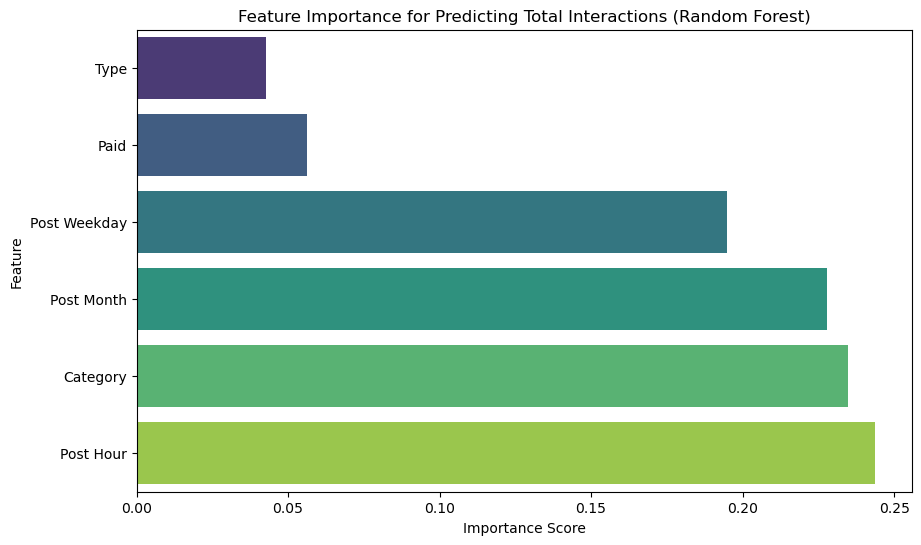

In [255]:
#  to visualize, first make df of importance
final_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': final_rf.feature_importances_
}).sort_values('Importance', ascending=False) #  largest importance on top

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=final_importance_df, palette='viridis')
plt.title('Feature Importance for Predicting Total Interactions (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [251]:
print("Final model feature importances:")
print(final_importance_df)

print(f"\nMost important feature: {final_importance_df.iloc[0]['Feature']} ({final_importance_df.iloc[0]['Importance']:.4f})")
print(f"Top 3 features account for {final_importance_df.head(3)['Importance'].sum():.1%} of importance")

Final model feature importances:
        Feature  Importance
4     Post Hour    0.243562
1      Category    0.234710
2    Post Month    0.227884
3  Post Weekday    0.194928
5          Paid    0.056310
0          Type    0.042605

Most important feature: Post Hour (0.2436)
Top 3 features account for 70.6% of importance


After building a 5-fold cross validated Random Forest Model to predict Total Interactions, we managed to increase the R^2 to approximately, 0.26, reflecting a 73% increase in R^2 in comparison to the baseline linear regression model. 

An R^2 of 0.26, while a large increase from our baseline, is admittedly poor. However, it's important to keep this result within the context of the data. The findings suggest that approximately 26% of the variability in Total Interaction can be attributed to the metadata of a post, not the content of the post itself. While it might be obvious that the actual content of a post may play a larger factor in predicting engagement outcomes, this analysis reveals that it would be unwise to ignore the impact post types, post scheduling, and paid promotion can have on the overall success of a post. While the creative content of a post undoubtedly plays a larger role, this analysis confirms that a strategic approach to post timing and promotion can have a measurable and predictable impact on engagement outcomes.
